## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [7]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [8]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

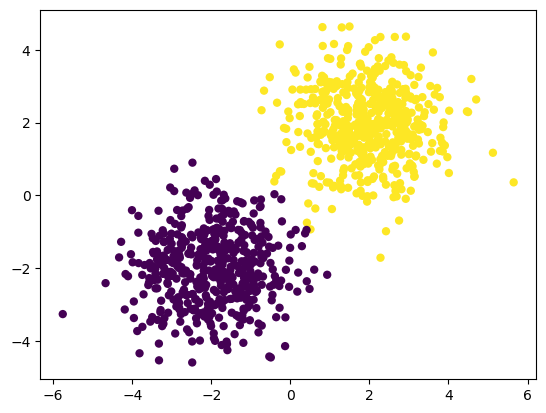

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

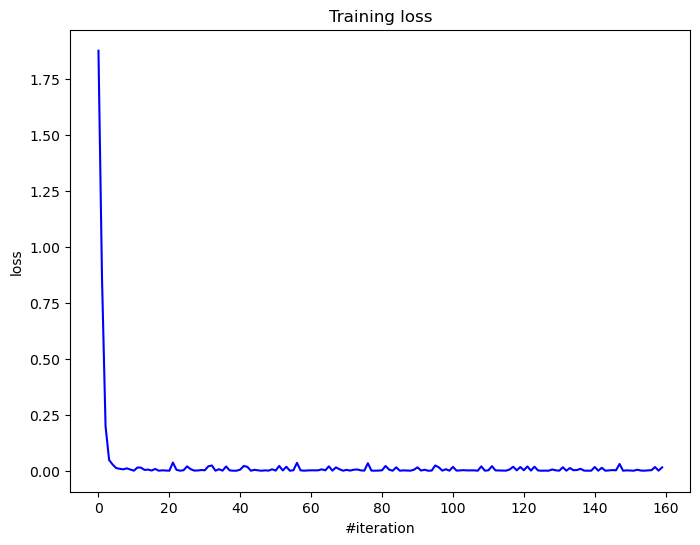

Current loss: 0.014952


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [2]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [68]:
X_train.shape, y_train.shape

((50000, 28, 28), (50000,))

In [3]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train = np.array(enc.fit_transform(y_train.reshape(-1, 1)).todense()) 
y_val = np.array(enc.transform(y_val.reshape(-1, 1)).todense()) 
y_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()) 

image_size = 28**2
X_train = X_train.reshape(X_train.shape[0], image_size)
X_val = X_val.reshape(X_val.shape[0], image_size)
X_test = X_test.reshape(X_test.shape[0], image_size)

In [70]:
X_train.shape, y_train.shape

((50000, 784), (50000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [12]:
# Your code goes here. ################################################

def train(net, optimizer):
    history_loss = []
    for _ in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            optimizer(net.getParameters(),
                        net.getGradParameters(),
                        optimizer_config,
                        optimizer_state)
            history_loss.append(loss) 
    return history_loss

## ReLU

In [13]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_relu = train(net, sgd_momentum)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 14s, sys: 4min 7s, total: 5min 21s
Wall time: 20.4 s


## ELU

In [14]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ELU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_elu = train(net, sgd_momentum)

Linear 784 -> 128
ELU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 16s, sys: 4min 9s, total: 5min 26s
Wall time: 20.8 s


## LeakyReLU

In [15]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(LeakyReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_relu_l = train(net, sgd_momentum)

Linear 784 -> 128
LeakyReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 17s, sys: 4min 20s, total: 5min 37s
Wall time: 21.5 s


## SoftPlus

In [16]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(SoftPlus())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_soft_plus = train(net, sgd_momentum)

Linear 784 -> 128
SoftPlus
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 18s, sys: 4min 22s, total: 5min 40s
Wall time: 21.7 s


## ReLU + BatchNormalization

In [17]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_relu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 16s, sys: 4min 15s, total: 5min 31s
Wall time: 21.1 s


## ELU + BatchNorm

In [18]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ELU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_elu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ELU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 17s, sys: 4min 15s, total: 5min 32s
Wall time: 21.2 s


## LeakyReLU + BatchNorm

In [19]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(LeakyReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_l_Relu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 19s, sys: 4min 17s, total: 5min 36s
Wall time: 21.4 s


## SoftPlus + BatchNorm

In [20]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(SoftPlus())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_softplus = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 18s, sys: 4min 21s, total: 5min 39s
Wall time: 21.6 s


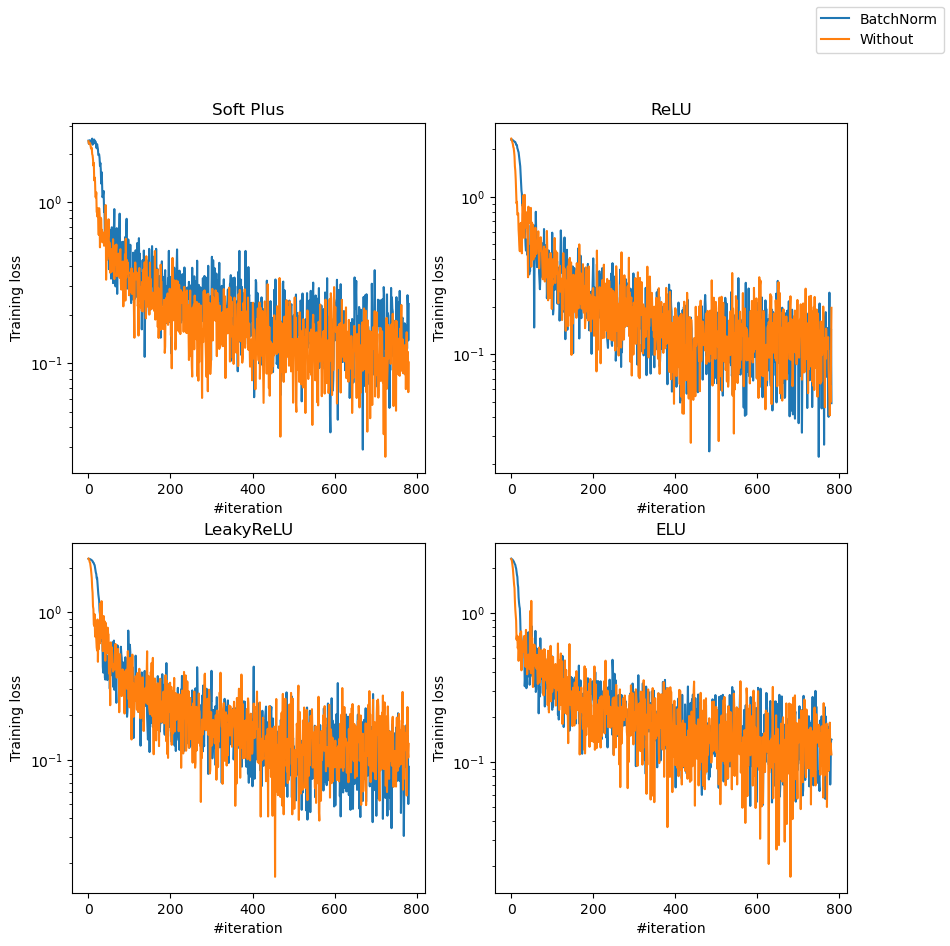

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].semilogy(loss_history_batchn_softplus, label='BatchNorm')
axs[0, 0].semilogy(loss_history_soft_plus, label='Without')
axs[0, 0].set_title('Soft Plus')

axs[0, 1].semilogy(loss_history_batchn_relu)
axs[0, 1].semilogy(loss_history_relu)
axs[0, 1].set_title('ReLU')

axs[1, 0].semilogy(loss_history_batchn_l_Relu)
axs[1, 0].semilogy(loss_history_relu_l)
axs[1, 0].set_title('LeakyReLU')

axs[1, 1].semilogy(loss_history_batchn_elu)
axs[1, 1].semilogy(loss_history_elu)
axs[1, 1].set_title('ELU')

for ax in axs.flat:
    ax.set(xlabel='#iteration', ylabel='Training loss')
fig.legend();

## Adam Oprimizer

In [22]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'beta1': 0.97, 'beta2': 0.98, 'epsilon': 1e-2}
optimizer_state = {}
loss_history_adam_relu = train(net, adam_optimizer)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: user 1min 18s, sys: 4min 14s, total: 5min 32s
Wall time: 21.2 s


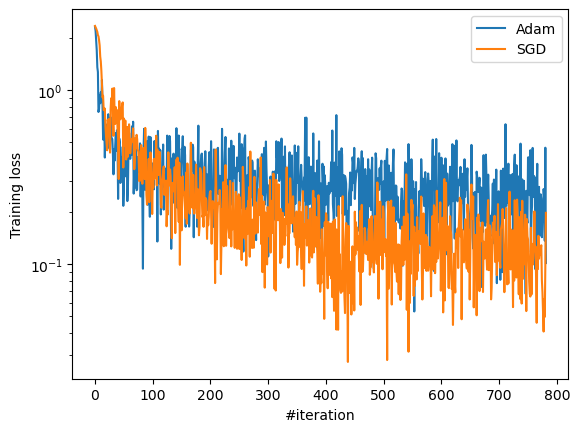

In [23]:
plt.semilogy(loss_history_adam_relu, label='Adam')
plt.semilogy(loss_history_relu, label='SGD')
plt.xlabel('#iteration')
plt.ylabel('Training loss')
plt.legend();

In [24]:
loss_history_adam_relu[-1]

0.10124489468590123

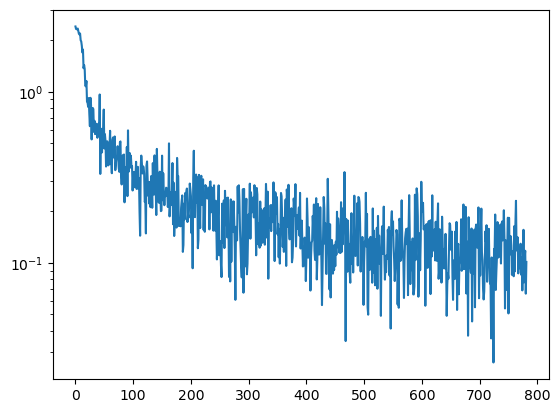

In [25]:
plt.semilogy(loss_history_soft_plus, label='Soft Plus')

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Как можно наблюдать, графики почти идентичны, а значит в рамках этой задачи нет особой разницы от перебора активаций и применения batchnorm'ов . 
По времени работы выигрывает ReLU (1min 14s) и ELU (1min 16s). LeakyReLU (1min 17s) и SoftPlus (1min 18s) занимают чуть больше времени.
BatchNormalization в данных случаях практически не помог,но добавляет небольшую задержку ко времени работы для каждой модели.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Print here your accuracy on test set. It should be around 90%.

In [5]:
def batch_gen(X, Y, batch_size):
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        batch_idx = indices[start : start + batch_size]
        x_batch, y_batch = X[batch_idx], Y[batch_idx]
        x_batch = x_batch.reshape(batch_size, np.prod(x_batch.shape[1:]))
        y_batch = y_batch.reshape(batch_size, np.prod(y_batch.shape[1:]))
        yield x_batch, y_batch
def train(model, X_train, y_train, batch_size, optimizer, optimizer_params):
    loss_history = []
    model.train()
    for x_batch, y_batch in batch_gen(X_train, y_train, batch_size):
        model.zeroGradParameters()
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)
        optimizer(model.getParameters(), model.getGradParameters(), optimizer_params, {})      
        loss_history.append(loss)
    return loss_history

In [11]:
criterion = ClassNLLCriterionUnstable()
model = Sequential()
model.add(Linear(784, 256))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(ReLU())
model.add(Linear(256, 64))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(ReLU())
model.add(Linear(64, 10))
model.add(BatchNormalization())
model.add(ReLU())
n_epoch = 10
batch_size = 100
optimizer_params = {'learning_rate': 3e-3, 'beta1': 0.9, 'beta2': 0.9, 'epsilon': 1e-10}
loss_history = []

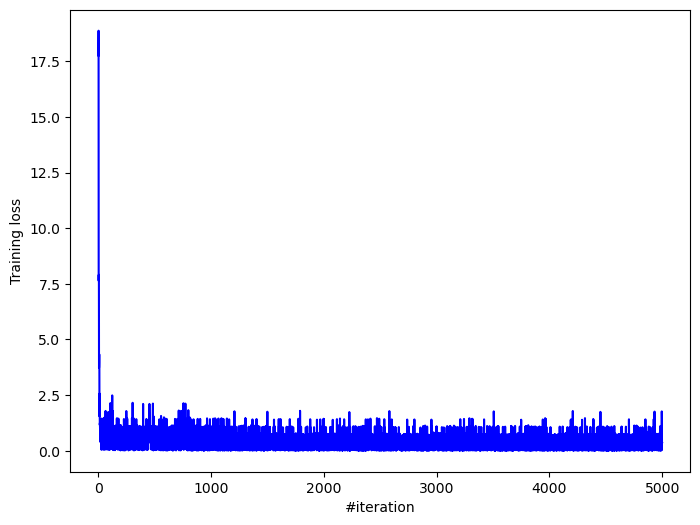

Current loss: 0.368899


In [12]:
model.train()

for i in range(n_epoch):
    loss_history.extend(train(model, X_train, y_train, batch_size, adam_optimizer, optimizer_params))

    display.clear_output(wait=False)
    plt.figure(figsize=(8, 6))
        
    plt.xlabel("#iteration")
    plt.ylabel("Training loss")
    plt.plot(loss_history, 'b')
    plt.show()
    print('Current loss: %f' % loss_history[-1])

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [14]:
model.evaluate()

n_preds = len(y_test)
predictions = model.forward(X_test.reshape(n_preds, image_size)).argmax(axis=1, keepdims=True).reshape(1, n_preds)

print("Accuracy:", np.sum(predictions == y_test) / n_preds)

Accuracy: 0.952


Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the week0_09 or Lab3_part2 notebooks for hints.

Good Luck!

In [15]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
import torchsummary
from sklearn.metrics import accuracy_score

In [16]:
class NN_Torch(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.flat = nn.Flatten()
        self.Linear1 = nn.Linear(784, 256)
        self.BN1 = nn.BatchNorm1d(256)
        self.DO1 = nn.Dropout(0.5)
        self.Linear2 = nn.Linear(256, 64)
        self.BN2 = nn.BatchNorm1d(64)
        self.DO2 = nn.Dropout(0.2)
        self.Linear3 = nn.Linear(64, 10)
        self.ReLU = nn.ReLU()
    def forward(self, x):
        x = self.flat(x)
        x1 = self.ReLU( self.DO1( self.BN1( self.Linear1(x) ) ) )
        x2 = self.ReLU( self.DO2( self.BN2( self.Linear2(x1) ) ) )
        x3 = self.ReLU( self.Linear3(x2) )
        return x3

In [17]:
train_mnist = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=64, shuffle=False)

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = NN_Torch().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs = 25

In [19]:
train_losses = []
test_losses = []
test_accs = []
train_accs = []
for epoch in range(num_epochs):
    model.train()
    opt.zero_grad()
    tr_loss_epoch = 0
    train_acc_epoch = 0
    for x_train, y_train in train_loader:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        pred = model(x_train)
        pred_labels = torch.argmax(pred,1).cpu().numpy()
        loss = loss_func(pred, y_train)
        tr_loss_epoch += loss.item()
        train_acc_epoch += accuracy_score( pred_labels, y_train.cpu().numpy() )
        loss.backward()
        opt.step()
    train_losses.append(tr_loss_epoch/len(train_loader)) 
    train_accs.append(train_acc_epoch/len(train_loader))
    
    
    model.eval()
    test_loss_epoch = 0
    test_acc_epoch = 0
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        with torch.no_grad():
            pred = model(x_test)
            pred_labels = torch.argmax(pred,1).cpu().numpy()
            loss = loss_func(pred, y_test)
            test_loss_epoch += loss.item()
            test_acc_epoch += accuracy_score( pred_labels, y_test.cpu().numpy() )
    test_losses.append(test_loss_epoch/len(test_loader))  
    test_accs.append(test_acc_epoch/len(test_loader))

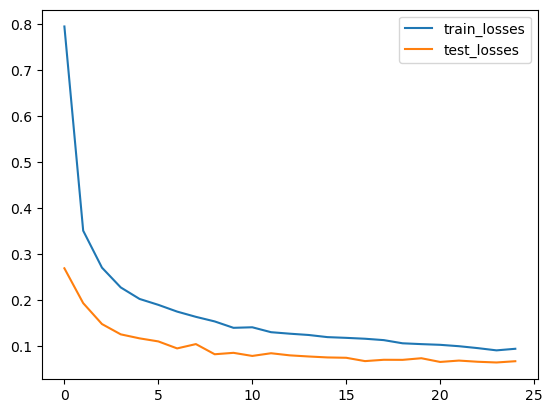

In [20]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses','test_losses'])

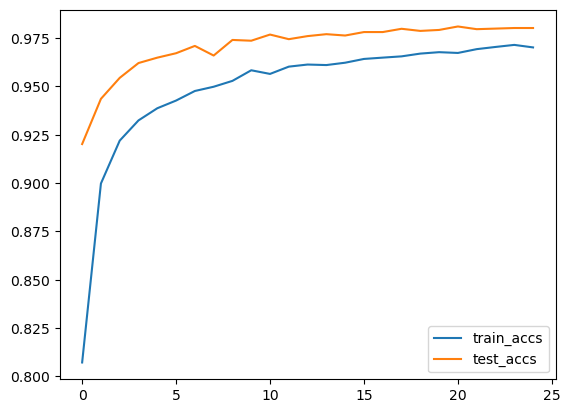

In [21]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs','test_accs'])

In [22]:
avg_acc = 0
for x, y in test_loader:
    pred = model(x.to(device))
    pred_labels = torch.argmax(pred,1).cpu().numpy() 
    avg_acc += accuracy_score( pred_labels, y.cpu().numpy() )
avg_acc = avg_acc/len(test_loader)

In [23]:
print(f'Average accuracy on test set = {avg_acc}')

Average accuracy on test set = 0.9801950636942676
